<center><h1>StreamSoNG (Streaming Soft Neural Gas)</h1></center>

<hr />

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
X1 = np.random.normal(-5, 2,(10, 2))
Y1 = np.zeros(len(X1))
X2 = np.random.normal(5, 1,(10, 2))
Y2 = np.zeros(len(X2)) + 1
X = np.concatenate((X1, X2), axis=0)
Y = np.concatenate((Y1, Y2), axis=0)

X.shape, Y.shape

((20, 2), (20,))

# Neural Gas (NG)

In [4]:
class NeuralGas():
    def __init__(self, num_prototypes, dimension, step_size, neighborhood_range):
        self.num_prototypes = num_prototypes
        self.dimension = dimension
#         self.prototypes = np.random.random((num_prototypes, dimension))
        self.prototypes = np.random.normal(0, 4, (num_prototypes, dimension))
        self.prototype_labels = np.full(num_prototypes, np.nan)
        self.step_size = step_size
        self.neighborhood_range = neighborhood_range
    
    def initialize_prototypes(self, X, Y):
        indices = np.random.choice(len(X), self.num_prototypes)
        for i in range(len(indices)):
            self.prototypes[i] = X[indices[i]]
            self.prototype_labels[i] = Y[indices[i]]
    
    def visualize(self, X, Y):
        fig, ax = plt.subplots()
        
        # data
        ax.scatter(X[:, 0], X[:, 1], label="data", c=Y, cmap="Pastel1")
        
        # prototypes
        ax.scatter(self.prototypes[:, 0], self.prototypes[:, 1], c=self.prototype_labels, cmap="Set1", label="prototypes", marker="x")
        
        plt.show()
        
    def get_distance(self, a, b):
        return np.sum(np.power(a - b, 2))
    
    def learn(self, X):
        idx = np.random.choice(len(X))
        x = X[idx]
        
        distances = np.zeros(self.num_prototypes)
        for i in range(len(distances)):
            distances[i] = self.get_distance(x, self.prototypes[i])
        indices = np.argsort(distances)
        
        for k, i in enumerate(indices, 1):
            delta = self.step_size * np.exp(-k / self.neighborhood_range) * (x - self.prototypes[i])
            self.prototypes[i] += delta

In [5]:
ng = NeuralGas(num_prototypes=10, dimension=2, step_size=1, neighborhood_range=1)
ng.initialize_prototypes(X, Y)

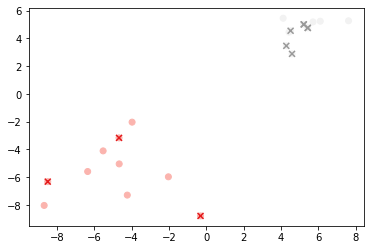

In [6]:
ng.visualize(X, Y)

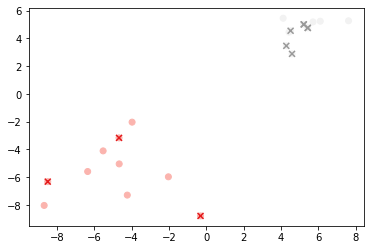

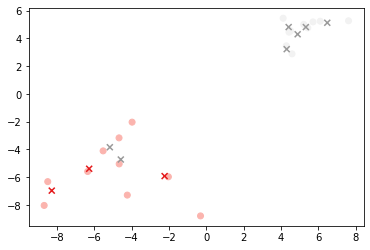

In [7]:
ng.visualize(X, Y)
for epoch in range(1000):
    ng.learn(X)
ng.visualize(X, Y)

# Probabilistic K-Nearest Neighbors (PKNN)

In [8]:
class PKNN():
    def __init__(self, prototypes, prototype_labels, K, fuzzifier):
        self.prototypes = prototypes
        self.prototype_labels = prototype_labels.astype("int")
        self.K = K
        self.fuzzifier = fuzzifier
    
    def get_distance(self, a, b):
        return np.sum(np.power(a - b, 2))
    
    def knn(self, A, B, n=5, ignore_diag=False):
        distances = np.full((len(A), len(B)), np.nan)
        for i in range(len(A)):
            for j in range(len(B)):
                if ignore_diag and i == j:
                    continue
                distances[i, j] = self.get_distance(A[i], B[j])
        sorted_indices = np.argpartition(distances, kth=range(n), axis=1)[:, :n]
        shortest_distances= np.full((len(A), n), np.nan)
        for i in range(len(shortest_distances)):
            shortest_distances[i] = distances[i, sorted_indices[i]]
        return sorted_indices, shortest_distances
    
    def estimate_radius(self, n=5):
        _, shortest_distances = self.knn(self.prototypes, self.prototypes, n=n, ignore_diag=True)
        fig, ax = plt.subplots()
        hist, bins = np.histogram(shortest_distances, bins=8)
        width = 0.7 * (bins[1] - bins[0])
        center = (bins[:-1] + bins[1:]) / 2
        ax.bar(center, hist, align='center', width=width)
        mean = np.mean(center)
        ax.plot([mean] * (np.max(hist)+1), np.arange(np.max(hist)+1), color="red")
        self.radius = mean
    
    def compute_fuzzy_membership(self, n_i, pred, actual):
        if pred == actual:
            return 0.51 + (n_i / self.K) * 0.49
        else:
            return (n_i / self.K) * 0.49
    
    def compute_typicality(self, x, p):
        return 1 / (1 + (self.get_distance(x, p) / self.radius) ** (1 / (self.fuzzifier-1)))

In [9]:
pknn = PKNN(prototypes=ng.prototypes, prototype_labels=ng.prototype_labels, K=3, fuzzifier=1.5)

131.30762372717652

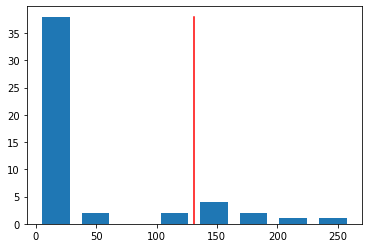

In [10]:
pknn.estimate_radius(n=5)
pknn.radius

In [11]:
C = len(np.unique(Y))
"C", C

('C', 2)

In [21]:
typicalities = np.full((len(X), len(pknn.prototypes)), np.nan)
sorted_indices, _ = pknn.knn(X, pknn.prototypes, n=pknn.K)
for i, idx in enumerate(sorted_indices):
    # crisp membership ========================================================
    crisp_memberships = np.zeros(C)
    for pred_idx in pknn.prototype_labels[idx]:
        crisp_memberships[pred_idx] += 1
    pred_class = np.argmax(crisp_memberships)
    # constraint check
    assert np.sum(crisp_memberships) == pknn.K
    
    # fuzzy membership ========================================================
    fuzzy_memberships = np.full(len(crisp_memberships), np.nan)
    for c, n_i in enumerate(crisp_memberships):
        fuzzy_memberships[c] = pknn.compute_fuzzy_membership(n_i=n_i, pred=pred_class, actual=Y[i])
    print("fuzzy_memberships", fuzzy_memberships)
    # constraint check
    assert np.max(fuzzy_memberships) > 0
    assert np.max(fuzzy_memberships) <= 1
    
    for k in idx:
        # typicality ==========================================================
        t = pknn.compute_typicality(X[i], pknn.prototypes[k])
        typicalities[i, k] = t
#         print(f"t_{i},{k} = {typicalities[i, k]}")

fuzzy_memberships [0.16333333 0.32666667]
fuzzy_memberships [0.16333333 0.32666667]
fuzzy_memberships [0.83666667 0.67333333]
fuzzy_memberships [0.16333333 0.32666667]
fuzzy_memberships [0.83666667 0.67333333]
fuzzy_memberships [0.16333333 0.32666667]
fuzzy_memberships [0.16333333 0.32666667]
fuzzy_memberships [0.83666667 0.67333333]
fuzzy_memberships [0.83666667 0.67333333]
fuzzy_memberships [0.16333333 0.32666667]
fuzzy_memberships [0.51 1.  ]
fuzzy_memberships [0.51 1.  ]
fuzzy_memberships [0.51 1.  ]
fuzzy_memberships [0.51 1.  ]
fuzzy_memberships [0.51 1.  ]
fuzzy_memberships [0.51 1.  ]
fuzzy_memberships [0.51 1.  ]
fuzzy_memberships [0.51 1.  ]
fuzzy_memberships [0.51 1.  ]
fuzzy_memberships [0.51 1.  ]


In [13]:
np.unique([0, 0, 3], return_counts=True)

(array([0, 3]), array([2, 1], dtype=int64))